# Import library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# GoogLeNet

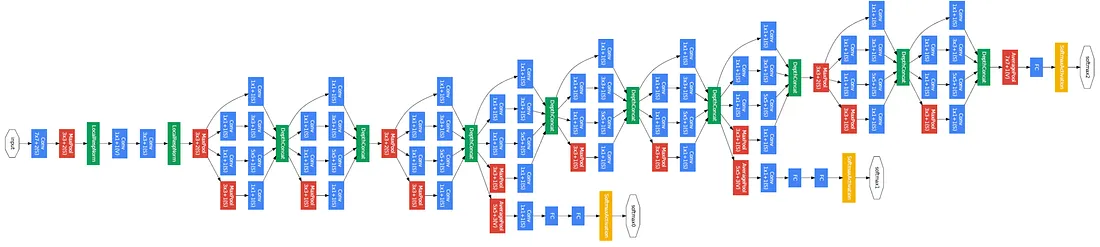

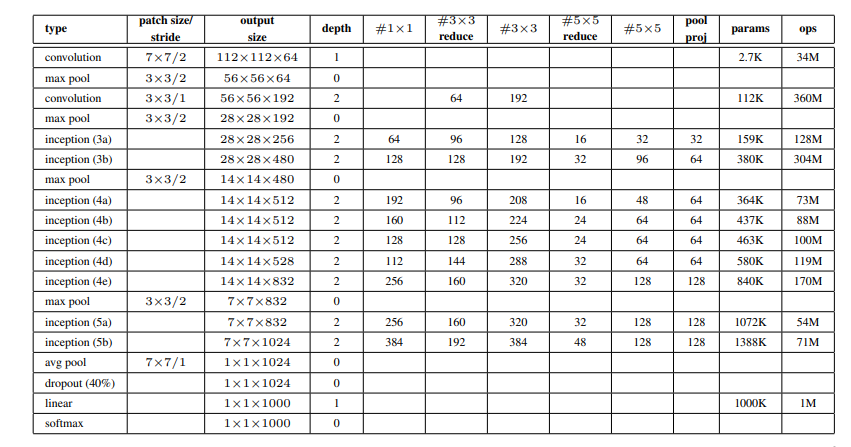

In [2]:
def conv1(in_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, 1, 1),
        nn.ReLU()
    )
    
    return model
    
def conv_1to3(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, mid_dim, 1, 1),
        nn.ReLU(),
        nn.Conv2d(mid_dim, out_dim, 3, 1, 1),
        nn.ReLU(),
    )
    
    return model

def conv_1to5(in_dim, mid_dim, out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim, mid_dim, 1, 1),
        nn.ReLU(),
        nn.Conv2d(mid_dim, out_dim, 5, 1, 2),
        nn.ReLU(),
    )
    
    return model

def pooling_conv1(in_dim, out_dim):
    model = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        nn.Conv2d(in_dim, out_dim, 1, 1),
        nn.ReLU()
    )
    
    return model

In [3]:
class InceptionModule(nn.Module):
    def __init__(self, in_dim, out_dim1, mid_dim3, out_dim3, mid_dim5, out_dim5, pool_dim):
        super(InceptionModule, self).__init__()

        # 1x1 Convolution
        self.conv1 = conv1(in_dim, out_dim1)
        
        # 1x1 Convolution -> 3x3 Convolution
        self.conv_1to3 = conv_1to3(in_dim, mid_dim3, out_dim3)
        
        # 1x1 Convolution -> 5x5 Convolution
        self.conv_1to5 = conv_1to5(in_dim, mid_dim5, out_dim5)
        
        # 3x3 MaxPooling -> 1x1 Convolution
        self.pooling_conv1 = pooling_conv1(in_dim, pool_dim)
        
    def forward(self, x):
        out_1 = self.conv1(x)
        out_2 = self.conv_1to3(x)
        out_3 = self.conv_1to5(x)
        out_4 = self.pooling_conv1(x)
        
        output = torch.cat([out_1, out_2, out_3, out_4], 1)
        return output

In [4]:
num_classes = 10
batch_size = 512
lr = 0.0002
num_epochs = 100

class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.layer3 = nn.Sequential(
            InceptionModule(192, 64, 96, 128, 16, 32, 32),             # inception (3a)
            InceptionModule(256, 128, 128, 192, 32, 96, 64),        # inception (3b)
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),   
        )
        
        self.layer4 = nn.Sequential(
            InceptionModule(480, 192, 96, 208, 16, 48, 64),          # inception (4a)
            InceptionModule(512, 160, 112, 224, 24, 64, 64),         # inception (4b)
            InceptionModule(512, 128, 128, 256, 24, 64, 64),        # inception (4c)
            InceptionModule(512, 112, 144, 288, 32, 64, 64),        # inception (4d)
            InceptionModule(528, 256, 160, 320, 32, 128, 128),    # inception (4e)
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.layer5 = nn.Sequential(
            InceptionModule(832, 256, 160, 320, 32, 128, 128),     # inception (5a)
            InceptionModule(832, 384, 192, 384, 48, 128, 128),    # inception (5b)
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        
        self.dropout = nn.Dropout2d(0.4)
        self.linear = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.dropout(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# Data

In [5]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = datasets.CIFAR10(root="./CIFAR10/", train=True, transform=transform, target_transform=None, download=False)
cifar10_test = datasets.CIFAR10(root="./CIFAR10/", train=False, transform=transform, target_transform=None, download=False)

train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(train_loader, classes):
    
    data_iter = iter(train_loader)  
    
    # 하나의 배치를 꺼냄
    images, labels = next(data_iter)
    
    # 이미지 모으기
    img_grid = torchvision.utils.make_grid(images)
    
    # Unnormalize
    img_grid = img_grid * 0.5 + 0.5
    
    # numpy 배열로 변환 후, 채널 순서를 (H, W, C)로 바꿔서 전달
    npimg = img_grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # 축 제거
    plt.show()
    
    # 6) 라벨 정보 출력
    #    len(labels)는 실제 배치 사이즈만큼 반복
    print('Labels:')
    print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))


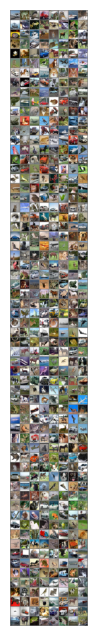

Labels:
plane  frog  bird   car truck  bird  ship  deer  ship   car  frog  deer   cat   car  frog  bird   car  ship  ship horse   cat  deer   dog horse  frog  deer   car  deer   cat  deer   cat horse  frog   dog   car   car horse   dog  ship plane  bird  bird  bird   cat horse plane  ship  ship   car   dog   car  ship   cat   car   cat truck horse   car truck   car   cat  deer  deer horse  bird  ship  bird plane   car   cat  bird truck   cat  ship plane   car  frog   car plane   cat truck  bird   dog   dog truck  bird   cat   dog  frog   dog plane  bird   cat  deer  ship   car   dog  deer truck   dog   car  ship truck   car   car   dog  ship  frog  deer plane   car   car  bird   cat  bird horse   car  frog  ship plane  frog horse   dog   car horse   car   cat plane   car   car  bird   car truck   cat plane horse  deer  bird   cat   dog  frog  bird plane  bird plane  bird   cat   car truck truck  bird  ship  deer  ship  bird truck horse  frog   dog  frog   cat plane  bird   car   car ho

In [7]:
show_random_images(train_loader, classes)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GoogLeNet().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

for i in model.named_children():
    print(i)

cuda
('layer1', Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
))
('layer2', Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
))
('layer3', Sequential(
  (0): InceptionModule(
    (conv1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
    )
    (conv_1to3): Sequential(
      (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_1to5): Sequential(
      (0): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (3): ReLU()
    )
    (pooling_

# Train

In [9]:
loss_arr = []
for i in range(num_epochs):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()

    if i % 10 ==0:
        print(loss)
        loss_arr.append(loss.cpu().detach().numpy())

tensor(2.1014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3347, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1870, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2198, device='cuda:0', grad_fn=<NllLossBackward0>)


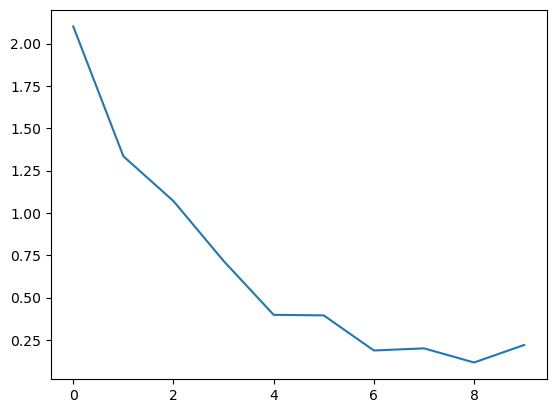

In [10]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()

# Test

In [13]:
correct = 0 # 맞은 개수
total = 0   # 전체 개수

model.eval()
with torch.no_grad():
    for image,label in test_loader:
        
        x = image.to(device)
        y = label.to(device)

        output = model.forward(x)
        # torch.max를 이용해 최대 값 및 최대값 인덱스를 뽑아냄 (인덱스만 사용)
        _,output_index = torch.max(output,1)
        
        # 전체 개수는 라벨의 개수로 더해줌 (batch_size, drop_last의 영향으로 데이터가 잘릴 수도 있기 때문에)
        total += label.size(0)
        
        # 모델의 결과의 최대값 인덱스와 라벨이 일치하는 개수를 더해줌
        correct += (output_index == y).sum().float()
    
    print("Accuracy of Test Data: {}%".format(100*correct/total))

Accuracy of Test Data: 63.97999954223633%
